In [16]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    DATASET_NAME = "google-research-datasets/go_emotions"
    DATASET_CONFIG = "simplified"
    NUM_LABELS = 28
    MAX_LENGTH = 128

    TRAIN_SAMPLES = 5_000
    TEST_SAMPLES = 500

    BATCH_TRAIN = 16
    BATCH_EVAL = 32
    EPOCHS = 3
    LR = 3e-5
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 100
    SEED = 42

    TOP_N_WORDS = 20

    OUTPUT_DIR = "./results"
    SAVE_DIR = "./fine-tuned-distilbert-goemotions"

# =============================================================================
# INSTALL & IMPORTS
# =============================================================================
!pip install -q transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, hamming_loss
from collections import Counter
import pandas as pd
import re

In [17]:
# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def print_device_info():
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

def clean_text_for_eda(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
def run_eda(dataset):
    print("\n========== EDA: GoEmotions Dataset ==========")

    train_df = dataset["train"].to_pandas()

    label_names = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
        'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
        'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
        'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]

    # ---------------------------------------------------------
    # 1. Label Distribution (Multi-label)
    # ---------------------------------------------------------
    print("\n1. Label Distribution Analysis:")

    label_counts = {label: 0 for label in label_names}
    for labels in train_df['labels']:
        for label_idx in labels:
            label_counts[label_names[label_idx]] += 1

    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    labels_plot, counts_plot = zip(*sorted_labels)

    plt.figure(figsize=(12, 6))
    plt.barh(labels_plot, counts_plot)
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.title('Top 15 Emotions Distribution (Train Set)')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 most common emotions:")
    for label, count in sorted_labels[:10]:
        print(f"  {label}: {count}")

    # ---------------------------------------------------------
    # 2. Number of labels per example
    # ---------------------------------------------------------
    train_df['num_labels'] = train_df['labels'].apply(len)

    plt.figure(figsize=(8, 5))
    train_df['num_labels'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Number of Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Number of Labels per Example')
    plt.tight_layout()
    plt.show()

    print(f"\nAverage number of labels per example: {train_df['num_labels'].mean():.2f}")
    print(f"Max number of labels: {train_df['num_labels'].max()}")

    # ---------------------------------------------------------
    # 3. Text Length Analysis
    # ---------------------------------------------------------
    train_df["char_length"] = train_df["text"].apply(len)
    train_df["word_length"] = train_df["text"].apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(train_df["word_length"], bins=50, ax=axes[0])
    axes[0].set_title("Word Count Distribution")

    sns.histplot(train_df["char_length"], bins=50, ax=axes[1])
    axes[1].set_title("Character Count Distribution")

    plt.tight_layout()
    plt.show()

    print("\nText Length Statistics:")
    print(train_df[["word_length", "char_length"]].describe())

    # ---------------------------------------------------------
    # 4. Sample texts for different emotions
    # ---------------------------------------------------------
    print("\n\nSample texts for different emotions:")
    for i, (label, count) in enumerate(sorted_labels[:5]):
        label_idx = label_names.index(label)
        sample = train_df[train_df['labels'].apply(lambda x: label_idx in x)].iloc[0]
        print(f"\n{label.upper()}:")
        print(f"  Text: {sample['text'][:100]}...")
        print(f"  All labels: {[label_names[idx] for idx in sample['labels']]}")

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data():
    dataset = load_dataset(Config.DATASET_NAME, Config.DATASET_CONFIG)

    train_data = dataset["train"].shuffle(seed=Config.SEED).select(
        range(min(Config.TRAIN_SAMPLES, len(dataset["train"])))
    )
    test_data = dataset["test"].shuffle(seed=Config.SEED).select(
        range(min(Config.TEST_SAMPLES, len(dataset["test"])))
    )

    return DatasetDict({"train": train_data, "test": test_data})


# =============================================================================
# TOKENIZATION
# =============================================================================
def tokenize_dataset(dataset, tokenizer):
    def tokenize_fn(examples):
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=Config.MAX_LENGTH,
            padding=False,
        )

        batch_labels = []
        for label_list in examples["labels"]:
            if not isinstance(label_list, list):
                label_list = [label_list]

            label_vector = [0.0] * Config.NUM_LABELS

            for label_idx in label_list:
                if 0 <= label_idx < Config.NUM_LABELS:
                    label_vector[label_idx] = 1.0

            batch_labels.append(label_vector)

        tokenized["labels"] = batch_labels
        return tokenized

    tokenized = dataset.map(
        tokenize_fn,
        batched=True,
        remove_columns=dataset["train"].column_names
    )

    return tokenized


# =============================================================================
# MODEL
# =============================================================================
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS,
        problem_type="multi_label_classification"
    )
    return tokenizer, model


# =============================================================================
# METRICS
# =============================================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    predictions = 1 / (1 + np.exp(-logits))

    binary_preds = (predictions > 0.5).astype(int)
    labels = labels.astype(int)

    hamming = hamming_loss(labels, binary_preds)

    from sklearn.metrics import f1_score
    micro_f1 = f1_score(labels, binary_preds, average='micro', zero_division=0)
    macro_f1 = f1_score(labels, binary_preds, average='macro', zero_division=0)

    subset_acc = np.mean([np.array_equal(l, p) for l, p in zip(labels, binary_preds)])

    return {
        "hamming_loss": hamming,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "subset_accuracy": subset_acc,
    }


# =============================================================================
# CUSTOM DATA COLLATOR - SIMPLIFIED
# =============================================================================
from dataclasses import dataclass
from typing import Any, Dict, List

@dataclass
class MultiLabelDataCollator:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        labels = [feature["labels"] for feature in features]

        batch = {
            "input_ids": [feature["input_ids"] for feature in features],
            "attention_mask": [feature["attention_mask"] for feature in features],
        }

        batch = self.tokenizer.pad(
            batch,
            padding=True,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(labels, dtype=torch.float)

        return batch


# =============================================================================
# TRAINING
# =============================================================================
def train_model(model, tokenized_data, tokenizer):
    data_collator = MultiLabelDataCollator(tokenizer=tokenizer)

    args = TrainingArguments(
        output_dir=Config.OUTPUT_DIR,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_TRAIN,
        per_device_eval_batch_size=Config.BATCH_EVAL,
        learning_rate=Config.LR,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="micro_f1",
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        report_to="none",
        seed=Config.SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    trainer.train()
    return trainer


# =============================================================================
# EVALUATION & ANALYSIS
# =============================================================================
def evaluate_model(trainer, tokenized_data):
    predictions = trainer.predict(tokenized_data["test"])

    logits = predictions.predictions
    probs = 1 / (1 + np.exp(-logits))
    binary_preds = (probs > 0.5).astype(int)

    labels = predictions.label_ids.astype(int)

    label_names = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
        'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
        'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
        'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]

    print("\nPer-Label Metrics:")
    print("="*80)

    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, binary_preds, average=None, zero_division=0
    )

    metrics_df = pd.DataFrame({
        'Label': label_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    metrics_df = metrics_df.sort_values('Support', ascending=False)
    print("\nTop 15 Labels by Support:")
    print(metrics_df.head(15).to_string(index=False))

    print("\n" + "="*80)
    print("Overall Metrics:")
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(
        labels, binary_preds, average='micro', zero_division=0
    )
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        labels, binary_preds, average='macro', zero_division=0
    )

    print(f"Micro - Precision: {micro_p:.4f}, Recall: {micro_r:.4f}, F1: {micro_f1:.4f}")
    print(f"Macro - Precision: {macro_p:.4f}, Recall: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print(f"Hamming Loss: {hamming_loss(labels, binary_preds):.4f}")

    subset_acc = np.mean([np.array_equal(l, p) for l, p in zip(labels, binary_preds)])
    print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")


# =============================================================================
# INFERENCE
# =============================================================================
def predict(text, model, tokenizer):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=Config.MAX_LENGTH
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.sigmoid(outputs.logits)[0]

    threshold = 0.5
    predicted_labels = []

    label_names = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
        'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
        'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
        'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]

    for idx, prob in enumerate(probs):
        if prob > threshold:
            predicted_labels.append((label_names[idx], prob.item()))

    predicted_labels.sort(key=lambda x: x[1], reverse=True)

    return predicted_labels


# =============================================================================
# MAIN PIPELINE
# =============================================================================
def main():
    set_seed(Config.SEED)
    print_device_info()

    dataset = load_data()

    run_eda(dataset)

    tokenizer, model = load_model()
    tokenized = tokenize_dataset(dataset, tokenizer)
    trainer = train_model(model, tokenized, tokenizer)

    evaluate_model(trainer, tokenized)

    model.save_pretrained(Config.SAVE_DIR)
    tokenizer.save_pretrained(Config.SAVE_DIR)
    print(f"\nModel saved to {Config.SAVE_DIR}")

    samples = [
        "I'm so happy and excited about this amazing news!",
        "This makes me really angry and frustrated.",
        "I feel so grateful for everything you've done for me.",
        "I'm confused about what just happened.",
    ]

    print("\n" + "="*80)
    print("PREDICTION EXAMPLES:")
    print("="*80)

    for text in samples:
        predictions = predict(text, model, tokenizer)
        print(f"\nText: {text}")
        print("Predicted emotions:")
        if predictions:
            for label, prob in predictions[:3]:
                print(f"  - {label}: {prob:.2%}")
        else:
            print("  - No emotion detected above threshold")

PyTorch: 2.9.0+cu126
CUDA available: True

========== EDA: GoEmotions Dataset ==========

1. Label Distribution Analysis:


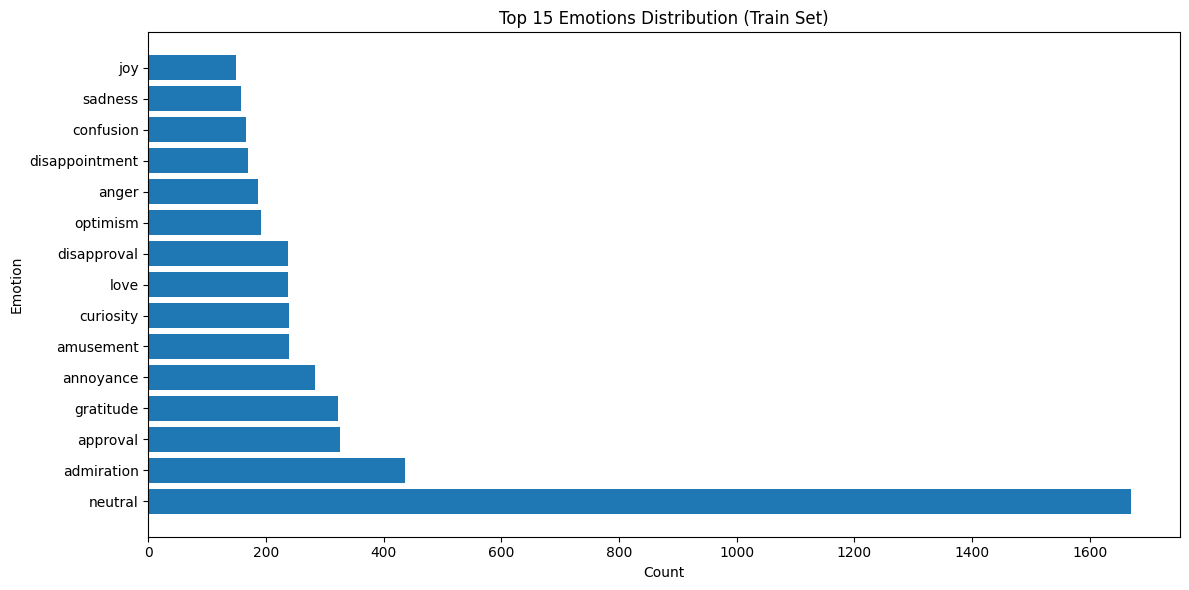


Top 10 most common emotions:
  neutral: 1670
  admiration: 436
  approval: 325
  gratitude: 323
  annoyance: 284
  amusement: 239
  curiosity: 239
  love: 238
  disapproval: 237
  optimism: 192


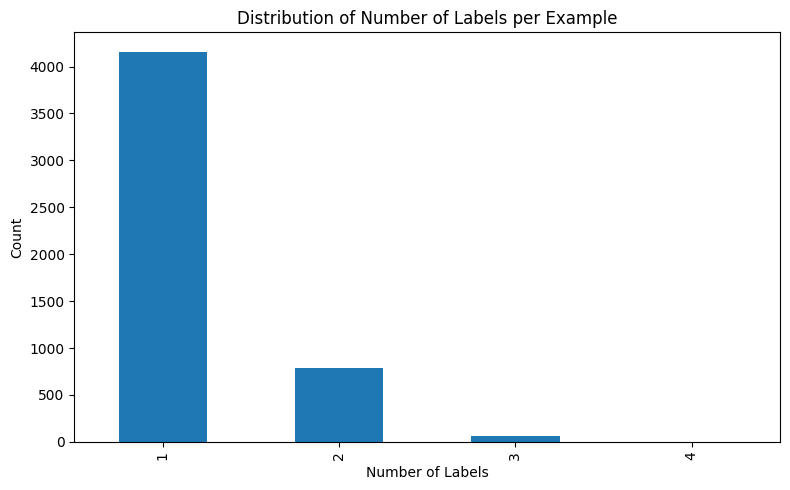


Average number of labels per example: 1.18
Max number of labels: 4


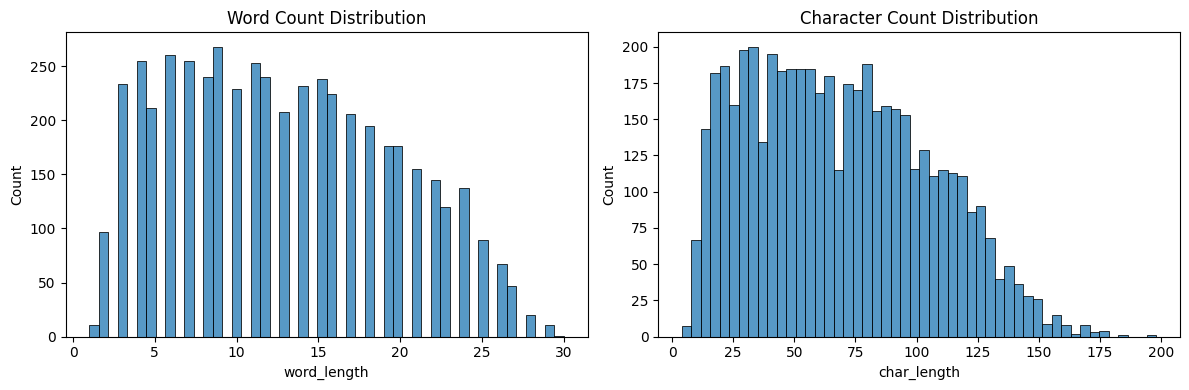


Text Length Statistics:
       word_length  char_length
count  5000.000000  5000.000000
mean     12.846400    68.360200
std       6.691141    36.418393
min       1.000000     4.000000
25%       7.000000    38.000000
50%      12.000000    65.000000
75%      18.000000    95.000000
max      30.000000   198.000000


Sample texts for different emotions:

NEUTRAL:
  Text: Now, this is epic! ...
  All labels: ['neutral']

ADMIRATION:
  Text: Oh so it is a separate guy filming, it’s actually impressive how synced up their speeds are...
  All labels: ['admiration']

APPROVAL:
  Text: Yes. I got accused of being a man or a bootlicker because I was a mod in a men's lib sub two years a...
  All labels: ['approval']

GRATITUDE:
  Text: Thx! Happy New Year!...
  All labels: ['gratitude']

ANNOYANCE:
  Text: So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of ca...
  All labels: ['annoyance']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Hamming Loss,Micro F1,Macro F1,Subset Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.152000,0.146543,0.040643,0.000000,0.000000,0.000000,0.417900,1196.372000,38.284000
2,0.132600,0.125333,0.036786,0.196568,0.046588,0.112000,0.399700,1250.949000,40.030000
3,0.120800,0.117487,0.035214,0.331072,0.081891,0.222000,0.326600,1530.949000,48.990000



Per-Label Metrics:

Top 15 Labels by Support:
         Label  Precision   Recall  F1-Score  Support
       neutral   0.641026 0.487013  0.553506      154
    admiration   0.750000 0.260870  0.387097       46
     gratitude   1.000000 0.937500  0.967742       32
      approval   0.000000 0.000000  0.000000       32
     annoyance   0.000000 0.000000  0.000000       31
     curiosity   0.000000 0.000000  0.000000       30
           joy   0.000000 0.000000  0.000000       26
   disapproval   0.000000 0.000000  0.000000       22
     amusement   0.000000 0.000000  0.000000       22
          love   1.000000 0.238095  0.384615       21
      optimism   0.000000 0.000000  0.000000       19
disappointment   0.000000 0.000000  0.000000       16
       disgust   0.000000 0.000000  0.000000       13
      surprise   0.000000 0.000000  0.000000       13
     confusion   0.000000 0.000000  0.000000       13

Overall Metrics:
Micro - Precision: 0.7262, Recall: 0.2144, F1: 0.3311
Macro - Precision

In [18]:
# =============================================================================
# RUN
# =============================================================================
main()